## Chicago Crime Forecasting (2012-2017)
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Boston. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots.

### Brief explanation of each column:
<ul>
<li>Unnamed: 0  - No idea what this is</li>
<li>ID - Unique crime identifier</li>
<li>Case Number - Unique case number recorded by Chicago PD</li>
<li>Date - Estimate Of when incident occured</li>
<li>IUCR - Illinois Uniform Crime Reporting code</li>
<li>Primary Type  - Primary description of IUCR code</li>
<li>Description - Secondary description of IUCR code</li>
<li>Location Description - Description of where incident occured</li>
<li>Arrest - Whether an arrest was made or not</li>
<li>Domestic - Whether incident was domestic-related or not</li>
<li>Beat - Smallest police geographic area</li>
<li>Block/District/Ward/Community Area/X Coordinate/Y Coordinate/Latitude/Longitude/Location - Location</li>
<li>FBI Code - Classification of crime according to the FBI's National Incident-Based Reporting System (NIBRS)</li>
<li>Year - Year that incident occured</li>
<li>Updated On - Date and time incident was last updated</li>
</ul>



### Importing libraries

In [36]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
#pd.set_option('display.max_rows', None)

### Loading dataset

In [37]:
df = pd.read_csv('chicago.csv', encoding='latin') #Thousands are seperated by commas in the CSV.

for col in df.columns.to_list(): #List all feature names
    print(col)

Unnamed: 0
ID
Case Number
Date
Block
IUCR
Primary Type
Description
Location Description
Arrest
Domestic
Beat
District
Ward
Community Area
FBI Code
X Coordinate
Y Coordinate
Year
Updated On
Latitude
Longitude
Location


### Data preprocessing

#### What are the datatypes used?

#### Let's take a look at the first 5 rows of the dataset

In [39]:
df.drop(['Unnamed: 0', 'ID', 'Case Number', 'Block' ,'IUCR','Updated On', 'FBI Code', 'Beat','Ward','Community Area', 'Location'
         , 'X Coordinate', 'Y Coordinate', 'District'], inplace=True, axis=1)

In [40]:
df.dtypes

Date                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Year                      int64
Latitude                float64
Longitude               float64
dtype: object

In [41]:
df.head(5)

Date            Primary Type              Description  \
0  05/03/2016 11:40:00 PM                 BATTERY  DOMESTIC BATTERY SIMPLE   
1  05/03/2016 09:40:00 PM                 BATTERY  DOMESTIC BATTERY SIMPLE   
2  05/03/2016 11:31:00 PM  PUBLIC PEACE VIOLATION         RECKLESS CONDUCT   
3  05/03/2016 10:10:00 PM                 BATTERY                   SIMPLE   
4  05/03/2016 10:00:00 PM                   THEFT           $500 AND UNDER   

  Location Description  Arrest  Domestic  Year   Latitude  Longitude  
0            APARTMENT    True      True  2016  41.864073 -87.706819  
1            RESIDENCE   False      True  2016  41.782922 -87.604363  
2               STREET   False     False  2016  41.894908 -87.758372  
3             SIDEWALK   False     False  2016  41.885687 -87.749516  
4            RESIDENCE   False      True  2016  41.886297 -87.761751

In [42]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df.index = pd.DatetimeIndex(df['Date'])
df['Month'] = df['Date'].dt.month
df['Hour'] = df['Date'].dt.hour
df.drop(['Date'], axis=1, inplace=True)

In [45]:
df.sort_index()

Primary Type  \
Date                                              
2012-01-01 00:00:00                       THEFT   
2012-01-01 00:00:00          DECEPTIVE PRACTICE   
2012-01-01 00:00:00          DECEPTIVE PRACTICE   
2012-01-01 00:00:00                       THEFT   
2012-01-01 00:00:00  OFFENSE INVOLVING CHILDREN   
...                                         ...   
2017-01-18 23:30:00                     BATTERY   
2017-01-18 23:35:00                     ROBBERY   
2017-01-18 23:40:00                     ROBBERY   
2017-01-18 23:45:00           WEAPONS VIOLATION   
2017-01-18 23:49:00                     ROBBERY   

                                             Description Location Description  \
Date                                                                            
2012-01-01 00:00:00        FINANCIAL ID THEFT: OVER $300               STREET   
2012-01-01 00:00:00                          BOGUS CHECK  TAVERN/LIQUOR STORE   
2012-01-01 00:00:00  FINANCIAL IDENTITY THEFT OVER $ 300            RESIDENCE   
2012-01-01 00:00:00                       $500 AND UNDER        BAR OR TAVERN   
2012-01-01 00:00:00       AGG SEX ASSLT OF CHILD FAM MBR            RESIDENCE   
...                                                  ...                  ...   
2017-01-18 23:30:00              DOMESTIC BATTERY SIMPLE             SIDEWALK   
2017-01-18 23:35:00                  VEHICULAR HIJACKING                ALLEY   
2017-01-18 23:40:00                       ARMED: HANDGUN               STREET   
2017-01-18 23:45:00             UNLAWFUL POSS OF HANDGUN             SIDEWALK   
2017-01-18 23:49:00                       ARMED: HANDGUN                ALLEY   

                     Arrest  Domestic  Year   Latitude  Longitude  Month  Hour  
Date                                                                            
2012-01-01 00:00:00   False     False  2012  41.985841 -87.804712      1     0  
2012-01-01 00:00:00   False     False  2012  41.844246 -87.725245      1     0  
2012-01-01 00:00:00   False     False  2012        NaN        NaN      1     0  
2012-01-01 00:00:00   False     False  2012  41.880600 -87.736438      1     0  
2012-01-01 00:00:00   False      True  2012        NaN        NaN      1     0  
...                     ...       ...   ...        ...        ...    ...   ...  
2017-01-18 23:30:00   False      True  2017        NaN        NaN      1    23  
2017-01-18 23:35:00   False     False  2017        NaN        NaN      1    23  
2017-01-18 23:40:00   False     False  2017        NaN        NaN      1    23  
2017-01-18 23:45:00    True     False  2017        NaN        NaN      1    23  
2017-01-18 23:49:00   False     False  2017        NaN        NaN      1    23  

[1456714 rows x 10 columns]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1456714 entries, 2016-05-03 23:40:00 to 2016-05-03 23:38:00
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Primary Type          1456714 non-null  object 
 1   Description           1456714 non-null  object 
 2   Location Description  1455056 non-null  object 
 3   Arrest                1456714 non-null  bool   
 4   Domestic              1456714 non-null  bool   
 5   Latitude              1419631 non-null  float64
 6   Longitude             1419631 non-null  float64
dtypes: bool(2), float64(2), object(3)
memory usage: 69.5+ MB


In [46]:
print(f'Null values found\n{df.isna().sum()}') #Check for null values

Null values found
Primary Type                0
Description                 0
Location Description     1658
Arrest                      0
Domestic                    0
Year                        0
Latitude                37083
Longitude               37083
Month                       0
Hour                        0
dtype: int64


In [52]:
df['Location Description'].fillna('Unknown', inplace=True)

In [65]:
plt.figure(figsize=(11,4))
df.resample('D').size().rolling(365).sum()
# plt.title('Rolling sum of all crimes from 2012 - 2017')
# plt.ylabel('Number of crimes')
# plt.xlabel('Days')
# plt.show()

Primary Type  Description  Location Description  Arrest  Domestic  \
Date                                                                            
2012-01-01          1451         1451                  1451    1451      1451   
2012-01-02           700          700                   700     700       700   
2012-01-03           805          805                   805     805       805   
2012-01-04           799          799                   799     799       799   
2012-01-05           871          871                   871     871       871   
...                  ...          ...                   ...     ...       ...   
2017-01-14           649          649                   649     649       649   
2017-01-15           600          600                   600     600       600   
2017-01-16           611          611                   611     611       611   
2017-01-17           659          659                   659     659       659   
2017-01-18           655          655                   655     655       655   

            Year  Latitude  Longitude  Month  Hour  
Date                                                
2012-01-01  1451      1333       1333   1451  1451  
2012-01-02   700       698        698    700   700  
2012-01-03   805       805        805    805   805  
2012-01-04   799       799        799    799   799  
2012-01-05   871       867        867    871   871  
...          ...       ...        ...    ...   ...  
2017-01-14   649         3          3    649   649  
2017-01-15   600         2          2    600   600  
2017-01-16   611         3          3    611   611  
2017-01-17   659         1          1    659   659  
2017-01-18   655         3          3    655   655  

[1845 rows x 10 columns]

<Figure size 1100x400 with 0 Axes>

### EDA

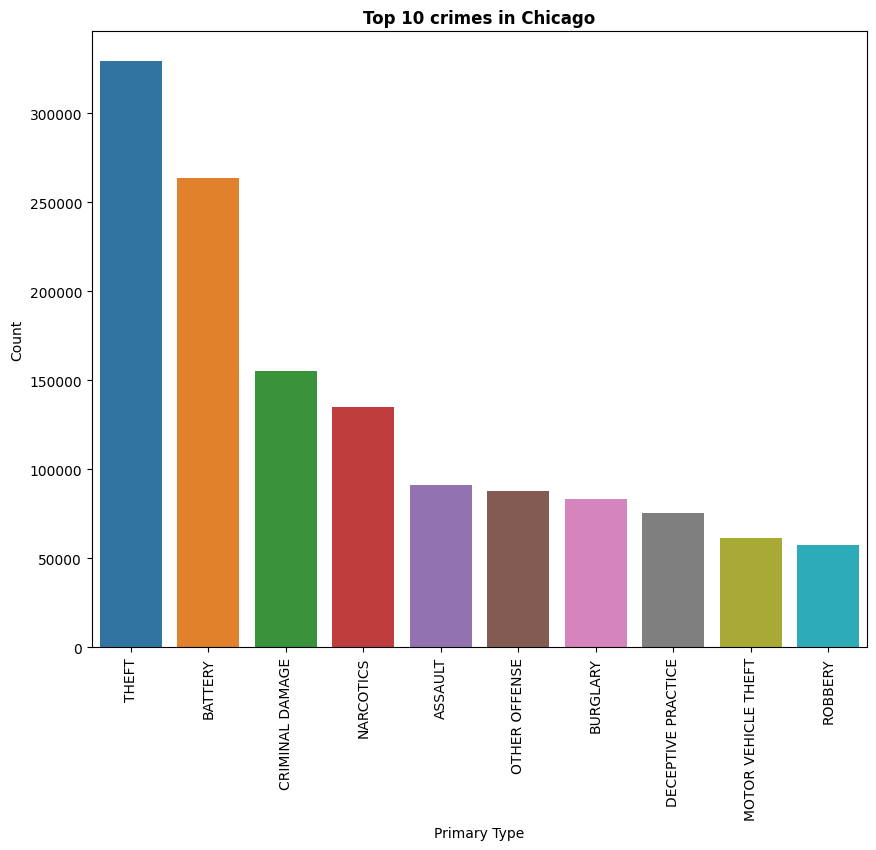

In [19]:
topcrimes = df['Primary Type'].value_counts()[:10]
plt.figure(figsize=(10,8))
sns.barplot(x=topcrimes.index, y=topcrimes.values)
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.title('Top 10 crimes in Chicago', weight='bold')
plt.xticks(rotation=90)
plt.show()

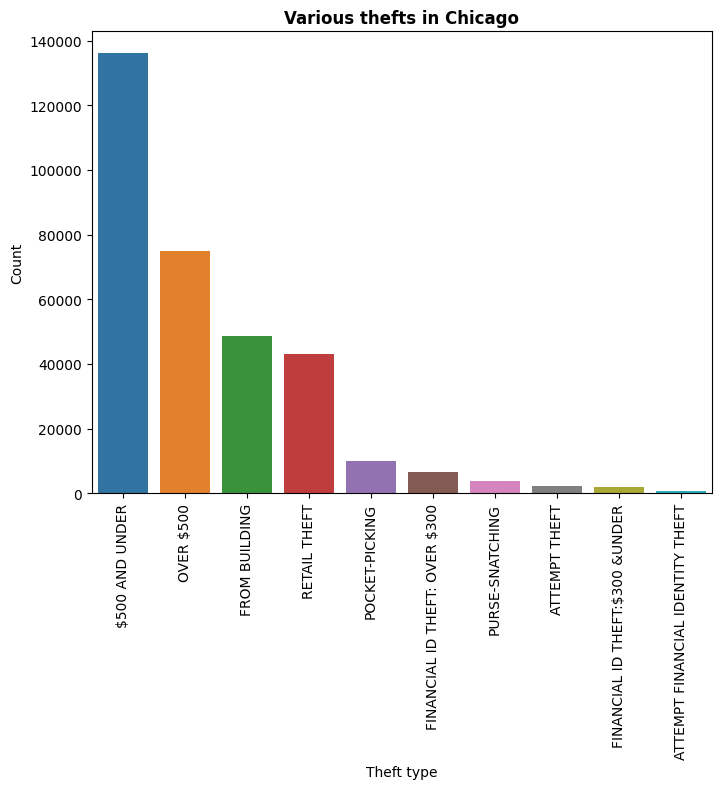

In [20]:
topthefts = df[df['Primary Type'] == 'THEFT']['Description'].value_counts()[:10]
plt.figure(figsize=(8,6))
sns.barplot(x=topthefts.index, y=topthefts.values)
plt.xlabel('Theft type')
plt.ylabel('Count')
plt.title('Various thefts in Chicago', weight='bold')
plt.xticks(rotation=90)
plt.show()

In [19]:
fig = px.scatter_mapbox(df.sample(frac=0.09), lat="Latitude", lon="Longitude",
                    zoom=8, height=600, size_max=30, color='Arrest')
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Thanks for reading!